In [1]:
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from nim_env import NimEnv, OptimalPlayer
import helpers as h

import torch
import torch.nn as nn
import torch.optim as optim
import WarningFunctions as wf


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#parameters
GAMMA = 0.99
buffer_size = 10000
BATCH_SIZE = 64
TARGET_UPDATE = 500


#-------------------------------- helpers DQN ----------------------------



# 3.2


Question 11

New game :  0
New game :  250
New game :  500
New game :  750
New game :  1000
New game :  1250
New game :  1500
New game :  1750


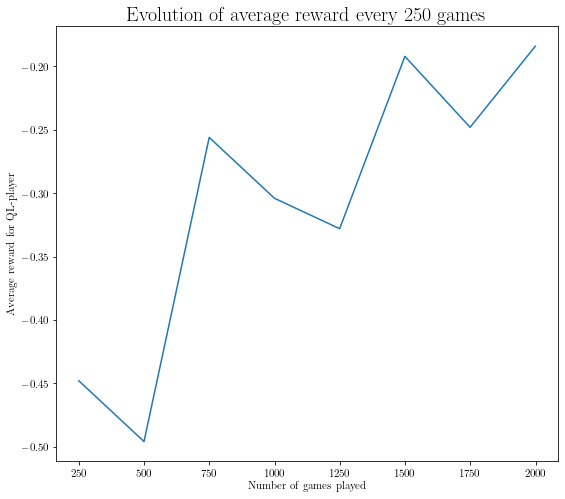

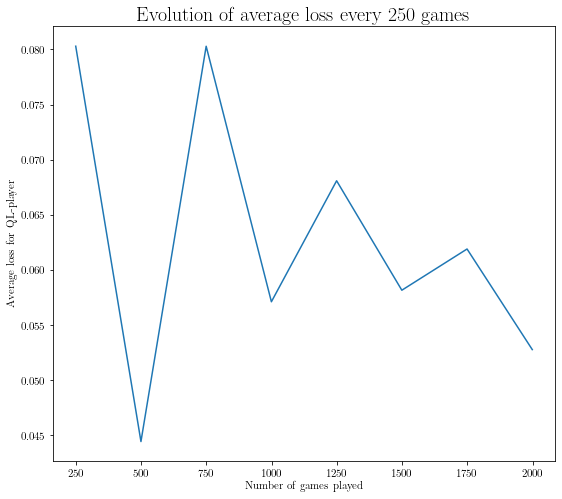

In [2]:
policy_net = h.DQN().to(device)
target_net = h.DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
memory = h.ReplayMemory(buffer_size)
h.Q11(policy_net, target_net, memory, eps = 0.1, eps_opt = 0.5, nb_games=2000)

Question 12


New game :  0


/Users/Anya48/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:972: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


New game :  250
New game :  500
New game :  750
New game :  1000
New game :  1250
New game :  1500
New game :  1750


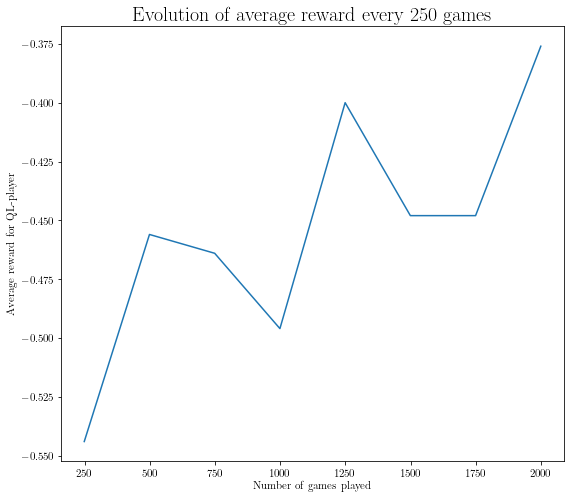

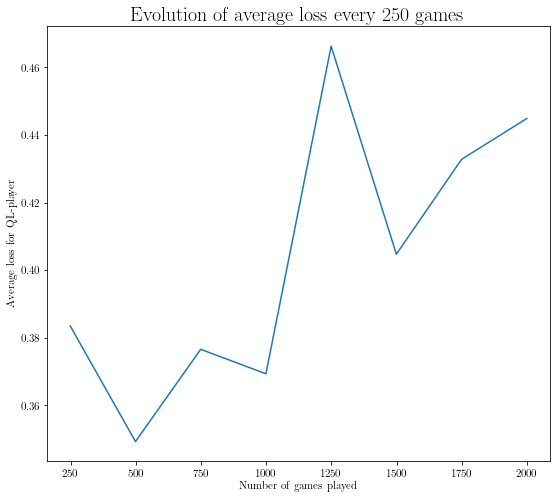

In [3]:
policy_net = h.DQN().to(device)
target_net = h.DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
memory = h.Memory_Q12()
h.Q12(policy_net, target_net, memory, eps = 0.1, eps_opt = 0.5, nb_games=2000, question='q3-12')

Question 13

In [6]:
def Q13(N_star, policy_net, target_net, memory : h.ReplayMemory, nb_games = 20000, eps_min = 0.1, eps_max = 0.8,  GAMMA = 0.99, buffer_size = 10000, BATCH_SIZE = 64, TARGET_UPDATE = 500,
       step = 250, seed = None, question = 'q3-13', nb_samples = 5, save = True):
    """
    Implements the solution to the 13th question
    - inputs: 
        - N_star: a list containing the values of n*, dtype: list
        - nb_games: the number of games to play. Default: 20000, dtype: int
        - eps_min: the minimal value for the exploration level of the QL-player. Default: 0.1, dtype: float
        - eps_max: the maximal value for the exploration level of the QL-player. Default: 0.8, dtype: float
        - alpha: learning rate of the QL-player. Default: 0.1, dtype: float
        - gamma: discount factor of the QL-player. Default: 0.99, dtype: float
        - step: number of games to play before calculating the average reward. Default: 250, dtype: int
        - seed: the user can set a given seed for reproducibility. Default: None
        - question: string used to differentiate between the plots for each question. 
            Only used if 'save' is True. Default: 'q2-3', dtype: str
        - nb_samples: if this number is higher than 1, the 'nb_games' are played several times and then averaged in order to take into account the schocasticity of te problem. Default: 5, dtype: int
        - save: if set to False, the plots are only displayed but not saved. Default: True, dtype: bool
    - outputs: 
        - a figure with a plot for each n* representing the average reward every 'step' games for the QL-player. According to the value of the argument 'nb_samples', two different figures can be produced. Figures are saved in a folder Data if the argument 'save' is set to True.
        - returns the final rewards for each n* as a dictionnary
    """
    #wf.Q2_warning(N_star, nb_games, eps_min, eps_max, alpha, gamma, step, question, nb_samples, save)
    
    plt.figure(figsize = (9, 8))
    legend = []
    Final_rewards = {}
    for j, n_star in enumerate(N_star):
        Rewards = np.zeros(int(nb_games / step))
        Steps = np.zeros(int(nb_games / step))
        Losses = np.zeros(int(nb_games / step))
        for s in range(nb_samples):
            env = NimEnv(seed = seed)
            eps = max(eps_min, eps_max * (1 - 1 / n_star))
            playerOpt = OptimalPlayer(epsilon = 0.5, player = 0)
            playerDQN = h.DQN_Player(player = 1, policy_net = policy_net, target_net= target_net, memory=memory, EPS_GREEDY = eps, GAMMA = GAMMA, buffer_size = buffer_size, BATCH_SIZE = BATCH_SIZE, TARGET_UPDATE = TARGET_UPDATE) 
            total_reward = 0.0
            total_loss = 0.0
            for i in range(nb_games):
                # switch turns at every game
                if i % 2 == 0:
                    playerOpt.player = 0
                    playerDQN.player = 1
                else:
                    playerOpt.player = 1
                    playerDQN.player = 0
        
                new_reward, new_loss = h.DQN_one_game(playerDQN, playerOpt, env)
                total_reward += new_reward
                if new_loss != None: #the loss might be None if the opt. player directly wins.
                    total_loss += new_loss
                if i % step == step - 1:
                    Rewards[i // step] += total_reward / step
                    Losses[i // step] += total_loss / step
                    total_reward = 0.
                    total_loss = 0.
                    Steps[i // step] = i
                env.reset(seed = seed)
                playerDQN.EPS_GREEDY = max(eps_min, eps_max * (1 - (i + 2) / n_star)) # change eps for the next game (current game is (i+1))
        Rewards = Rewards / nb_samples
        plt.plot(Steps, Rewards)
        Final_rewards['{}'.format(n_star)] = Rewards[-1]
        legend.append(r"$n_* = {}$".format(n_star))
    plt.legend(legend)
    plt.title('Evolution of average reward with decrease of exploration level')
    plt.xlabel('Number of games played')
    plt.ylabel('Average reward for QL-player')
    if save:
        if nb_samples > 1:
            plt.savefig('./Data/' + question + '_' + str(nb_samples) + '_samples.png')
        else:
            plt.savefig('./Data/' + question + '.png')
    return Final_rewards

In [8]:
policy_net = h.DQN().to(device)
target_net = h.DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
memory = h.ReplayMemory(buffer_size)
N_star = [1, 1000, 5000, 10000]
Q13(N_star, policy_net, target_net, memory, nb_games = 20000, nb_samples = 1)


Question 14